In [1]:
"""" 
compute wind power over the North Atlantic (including GOM) from
(1) RTOFS surface.now hourly analysis data & 
(2) GFS sfc data (forecast hours: 1-6)
"""
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import sys
from scipy import interpolate
path_nhchi = os.path.expanduser('~/Documents/projects/analytical-tools/py_nhchi/')
# adding to the system path
sys.path.insert(0, path_nhchi)
from convert_dir import vector_dir_to_from
from mystats import bandpass
from values_to_colors import values_to_rgba
sys.path.insert(0, path_nhchi+'area-master')
# "area" library is from https://github.com/scisco/area
from area import area

In [2]:
year = '2023'
# datelim = [datetime.datetime(int(year),8,1), datetime.datetime(int(year),9,1)]
datelim = [datetime.datetime(int(year),9,5), datetime.datetime(int(year),11,4)]
pathG = '/Users/chi/Documents/projects/sd-ni-wp/check_model/check_GFS/GFS.merge.sfc.'+\
    datelim[0].strftime('%Y%m%d')+'-'+datelim[-1].strftime('%Y%m%d')+'.nc'
pathR = '/Users/chi/Documents/projects/sd-ni-wp/check_model/check_RTOFS/RTOFS.merge.surface.now.'+\
    datelim[0].strftime('%Y%m%d')+'-'+datelim[-1].strftime('%Y%m%d')+'.nc'

dsG = nc.Dataset(pathG)
dsR = nc.Dataset(pathR)
print(dsG)
print('====================')
print(dsR)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: Merged files for GFS sfc data between 20230905 and 20231104
    subtitle: Only selected variables for are merged here. The data is hourly with ~0.117 deg horizontal resolution.
    dimensions(sizes): time(1464), longitude(615), latitude(329)
    variables(dimensions): float64 time(time), float64 LON(latitude, longitude), float64 LAT(latitude, longitude), float64 UFLX_AVE(time, latitude, longitude), float64 VFLX_AVE(time, latitude, longitude)
    groups: 
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: Merged files for RTOFS surface.now. data between 20230905 and 20231104
    subtitle: Only selected variables for are merged here. The data is hourly with 0.08 deg horizontal resolution.
    dimensions(sizes): time(1464), depth(1), longitude(901), latitude(551)
    variables(dimensions): float64 depth(depth), float64 time(time), f

In [4]:
print('shape of RTOFS velocity, lon:',dsR['U_VELOCITY'].shape, dsR['LONGITUDE'].shape)
print('min & max of RTOFS u-velocity',np.nanmin(dsR['U_VELOCITY']),np.nanmax(dsR['U_VELOCITY']))
print('='*30)
print('shape of GFS UFLX, lon:',dsG['UFLX_AVE'].shape, dsG['LON'].shape)
print('min & max of GFS UFLX',np.nanmin(dsG['UFLX_AVE']),np.nanmax(dsG['UFLX_AVE']))

shape of RTOFS velocity, lon: (1464, 1, 551, 901) (551, 901)
min & max of RTOFS u-velocity -3.4128530025482178 1.2676506002282294e+30
shape of GFS UFLX, lon: (1464, 329, 615) (329, 615)
min & max of GFS UFLX -5.345659255981445 5.723142623901367


In [5]:
''' Read RTOFS data '''
## read data & set limits of the box
LON_R = dsR['LONGITUDE'][:]
LON_R[LON_R> 180] = LON_R[LON_R> 180]-360
LAT_R = dsR['LATITUDE'][:]
U_R = np.squeeze( dsR['U_VELOCITY'][:] )
V_R = np.squeeze( dsR['V_VELOCITY'][:] )
U_R[U_R> 1e3] = np.nan
V_R[V_R> 1e3] = np.nan
dtime_R = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=dt) \
                  for dt in dsR['time'][:]])
print('shape of LON_R, LAT_R, V_R:',LON_R.shape, LAT_R.shape, V_R.shape)
# dsR.close()
print('RTOFS longitude & latitude limits:',np.min(LON_R),np.max(LON_R),np.min(LAT_R),np.max(LAT_R))
print('RTOFS time limits:',np.min(dtime_R),np.max(dtime_R))

shape of LON_R, LAT_R, V_R: (551, 901) (551, 901) (1464, 551, 901)
RTOFS longitude & latitude limits: -101.9200439453125 -29.9200439453125 7.577810764312744 45.77324676513672
RTOFS time limits: 2023-09-04 00:00:00 2023-11-03 23:00:00


In [5]:
''' Give RTOFS a lon/ lat limits and plot time series of u/v
'''
# lonlim = np.array([-98, -30])
# latlim = np.array([7.5, 40])
# ### 
# ilon = np.where( (LON_R[0,:]>= lonlim[0]) & (LON_R[0,:]< lonlim[1]) )[0]
# ilat = np.where( (LAT_R[:,0]>= latlim[0]) & (LAT_R[:,0]< latlim[1]) )[0]
# print('lengths of ilat, ilon:',len(ilat),len(ilon))

' Give RTOFS a lon/ lat limits and plot time series of u/v\n'

Lat_R[ilat]: (551,)


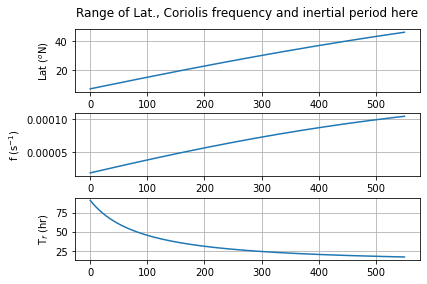

In [6]:
''' For each latitude, give a frequency limit to filter timeseries to NI band 
(try 0.8f-1.2f for each latitudes)'''
u_bp = np.nan*np.ones( (len(dtime_R), LON_R.shape[0], LON_R.shape[1]) )
v_bp = u_bp.copy()
f_lat = 2*(2*np.pi/86400)*np.sin(LAT_R[:,0]/180*np.pi) # 1/s
T_lat = 2*np.pi/f_lat/3600 # hr
print('Lat_R[ilat]:',LAT_R[:,0].shape)
plt.subplot(3,1,1)
plt.plot(LAT_R[:,0]); plt.ylabel('Lat ($^o$N)'); plt.grid()
plt.subplot(3,1,2)
plt.plot(f_lat); plt.ylabel('f (s$^{-1}$)'); plt.grid()
plt.subplot(3,1,3)
plt.plot(T_lat); plt.ylabel('T$_f$ (hr)'); plt.grid()
plt.suptitle('Range of Lat., Coriolis frequency and inertial period here')
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.35)

In [7]:
''' go through each grid and compute bandpass (NI) current velocities 
(~1 mins per latitude with 40 deg longitudes, ~1.8 mins per latitude with 73 deg longitudes)''' 
n_f = np.array([0.8,1.2])
dsec_RTOFS = (dtime_R[1]-dtime_R[0]).total_seconds()
###
plt.clf()
plt.gcf().set_size_inches(18, 5)
plt.rcParams.update({'font.size': 13})
for icnt in range( 75,LAT_R.shape[0] ):
    # print(icnt, lat_i)
    f_bp = np.array([n_f[0]*f_lat[icnt], n_f[1]*f_lat[icnt]])
    bp_sec = 2*np.pi/f_bp
    for jcnt in range( LON_R.shape[1] ):
        # print(jcnt, lon_j)
        u_bp[:,icnt,jcnt],_,_,_,_ = bandpass( np.squeeze( U_R[:,icnt,jcnt] ), dsec_RTOFS,bp_sec[0],bp_sec[1],2 )
        v_bp[:,icnt,jcnt],_,_,_,_ = bandpass( np.squeeze( V_R[:,icnt,jcnt] ), dsec_RTOFS,bp_sec[0],bp_sec[1],2 )
    print('Done with',LAT_R[icnt,0])
    # break

Done with 13.474061012268066
Done with 13.551846504211426
Done with 13.629606246948242
Done with 13.707341194152832
Done with 13.785049438476562
Done with 13.86273193359375
Done with 13.940388679504395
Done with 14.018019676208496
Done with 14.095623970031738
Done with 14.173202514648438
Done with 14.250753402709961
Done with 14.328278541564941
Done with 14.405776977539062
Done with 14.483247756958008
Done with 14.560691833496094
Done with 14.63810920715332
Done with 14.715498924255371
Done with 14.792860984802246
Done with 14.870195388793945
Done with 14.947502136230469
Done with 15.024781227111816
Done with 15.102032661437988
Done with 15.179255485534668
Done with 15.256449699401855
Done with 15.333616256713867
Done with 15.410754203796387
Done with 15.487863540649414
Done with 15.56494426727295
Done with 15.641996383666992
Done with 15.719018936157227
Done with 15.796011924743652
Done with 15.872976303100586
Done with 15.949911117553711
Done with 16.026817321777344
Done with 16.1036

<Figure size 1296x360 with 0 Axes>

In [8]:
''' Read GFS data '''
LON_G = dsG['LON'][:]
LON_G[LON_G> 180] = LON_G[LON_G> 180]-360
LAT_G = dsG['LAT'][:]
UFLX_AVE = np.squeeze( dsG['UFLX_AVE'][:] )
VFLX_AVE = np.squeeze( dsG['VFLX_AVE'][:] )
UFLX_AVE[UFLX_AVE> 1e3] = np.nan
VFLX_AVE[VFLX_AVE> 1e3] = np.nan
dtime_G = np.array([datetime.datetime(int(year),1,1)+datetime.timedelta(seconds=dt) \
                  for dt in dsG['time'][:]])
print('shape of LON_G, LAT_G, VFLX_AVE:',LON_G.shape, LAT_G.shape, VFLX_AVE.shape)
print('GFS longitude & latitude limits:',np.min(LON_G),np.max(LON_G),np.min(LAT_G),np.max(LAT_G))
print('GFS time limits:',np.min(dtime_G),np.max(dtime_G))
# dsG.close()

shape of LON_G, LAT_G, VFLX_AVE: (329, 615) (329, 615) (1464, 329, 615)
GFS longitude & latitude limits: -101.953125 -30.0 7.556133668527031 45.98112279618861
GFS time limits: 2023-09-05 01:00:00 2023-11-05 00:00:00


In [9]:
# ''' Try interpolate surface zonal momentum flux to RTOFS spatial grids using interpolate.RegularGridInterpolator 
# b/c interpolate.interp2d has been removed in Scipy 1.14.0 & gives warning messages '''
# x_G = LON_G[0,:][:]
# y_G = LAT_G[:,0][:]
# ilon = np.where( (LON_R[0,:]>= lonlim[0]) & (LON_R[0,:]< lonlim[1]) )[0]
# ilat = np.where( (LAT_R[:,0]>= latlim[0]) & (LAT_R[:,0]< latlim[1]) )[0]
# x_R = LON_R[0,ilon][:]
# y_R = LAT_R[ilat,0][:]
# UFLX_AVE_onR = np.nan*np.ones( (len(dtime_R),len(y_R),len(x_R)) )
# VFLX_AVE_onR = UFLX_AVE_onR.copy()
# for t in range( len(dtime_R) ):
#     it_G = np.where( dtime_G == dtime_R[t] )[0]
#     if len(it_G) == 1:
#         f_U = interpolate.RegularGridInterpolator((x_G,y_G),np.squeeze(UFLX_AVE[t,:,:].transpose()), fill_value=np.nan, bounds_error=False);
#         # print(dtime_G[it_G], dtime_R[t])
#         f_V = interpolate.RegularGridInterpolator((x_G,y_G),np.squeeze(VFLX_AVE[t,:,:].transpose()), fill_value=np.nan, bounds_error=False);
#         for i, lat in enumerate( y_R ):
#             for j, lon in enumerate( x_R ):
#                 UFLX_AVE_onR[t,i,j] = f_U( (lon, lat) )
#                 VFLX_AVE_onR[t,i,j] = f_V( (lon, lat) )
#         # plt.pcolormesh(x_R, y_R, VFLX_AVE_onR[t,:,:])
#         # plt.colorbar()
#         print(dtime_R[t])
#         break

In [10]:
''' Try interpolate surface zonal momentum flux to RTOFS spatial grids using interpolate.griddata 
    (<2 mins per one day for the entire domain (103W-30W, 7.5N-46N))
    In contrast, it takes ~4.5 mins per day to interpolate to RTOFS spatial grids for domain: 98W~30W, 7.5N~40N'''
print('LON_G shape:',LON_G.shape,'LON_R shape:',LON_R.shape)
UFLX_AVE_onR = np.nan*np.ones( (len(dtime_R),LON_R.shape[0],LON_R.shape[1]) )
VFLX_AVE_onR = UFLX_AVE_onR.copy()
for t in range( len(dtime_R) ):
    it_G = np.where( dtime_G == dtime_R[t] )[0]
    if len(it_G) == 1:
        Z = interpolate.griddata((LON_G.flatten(), LAT_G.flatten()), UFLX_AVE[t,:,:].flatten(), \
                                 (LON_R.flatten(), LAT_R.flatten()), method='linear')
        UFLX_AVE_onR[t,:,:] = np.reshape( Z, (LON_R.shape[0],LON_R.shape[1]) )
        Z = interpolate.griddata((LON_G.flatten(), LAT_G.flatten()), VFLX_AVE[t,:,:].flatten(), \
                                 (LON_R.flatten(), LAT_R.flatten()), method='linear')
        VFLX_AVE_onR[t,:,:] = np.reshape( Z, (LON_R.shape[0],LON_R.shape[1]) )
        print('Done griddata for',dtime_R[t],'t index=',t)

LON_G shape: (329, 615) LON_R shape: (551, 901)
Done griddata for 2023-09-05 01:00:00 t index= 25
Done griddata for 2023-09-05 02:00:00 t index= 26
Done griddata for 2023-09-05 03:00:00 t index= 27
Done griddata for 2023-09-05 04:00:00 t index= 28
Done griddata for 2023-09-05 05:00:00 t index= 29
Done griddata for 2023-09-05 06:00:00 t index= 30
Done griddata for 2023-09-05 07:00:00 t index= 31
Done griddata for 2023-09-05 08:00:00 t index= 32
Done griddata for 2023-09-05 09:00:00 t index= 33
Done griddata for 2023-09-05 10:00:00 t index= 34
Done griddata for 2023-09-05 11:00:00 t index= 35
Done griddata for 2023-09-05 12:00:00 t index= 36
Done griddata for 2023-09-05 13:00:00 t index= 37
Done griddata for 2023-09-05 14:00:00 t index= 38
Done griddata for 2023-09-05 15:00:00 t index= 39
Done griddata for 2023-09-05 16:00:00 t index= 40
Done griddata for 2023-09-05 17:00:00 t index= 41
Done griddata for 2023-09-05 18:00:00 t index= 42
Done griddata for 2023-09-05 19:00:00 t index= 43
Do

LON_R shape: (551, 901) LON_G shape: (329, 615)
LON_R range: -101.9200439453125 - -29.9200439453125
LAT_R range: 7.577810764312744 - 45.77324676513672
u_bp shape (1464, 551, 901)
UFLX_AVE_onR shape: (1464, 551, 901)
0.018167427812448827
(1464, 551, 901) (1464, 551, 901)


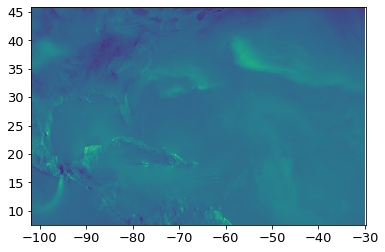

In [11]:
''' print data shapes to be written to files '''
print('LON_R shape:',LON_R.shape,'LON_G shape:',LON_G.shape)
print('LON_R range:',LON_R[0,0],'-',LON_R[0,-1])
print('LAT_R range:',LAT_R[0,0],'-',LAT_R[-1,0])
print('u_bp shape',u_bp.shape)
print('UFLX_AVE_onR shape:',UFLX_AVE_onR.shape)
''' plot '''
print(np.sum(np.isnan(UFLX_AVE_onR))/len(UFLX_AVE_onR.flatten()))
plt.pcolormesh(LON_R, LAT_R, UFLX_AVE_onR[-1,:,:])
print(UFLX_AVE_onR.shape, u_bp.shape)

In [12]:
''' write momentum flux (on RTOFS spatial grids) & RTOFS bandpass (NI) surface currents '''
try: ncfile.close()  # just to be safe, make sure dataset is not already open.
except: pass
tlim_str = dtime_R[0].strftime('%Y%m%d')+'-'+dtime_R[-1].strftime('%Y%m%d')
xylim_str = '{:.1f}N-{:.1f}N_{:.1f}-{:.1f}'.format(LAT_R[0,0],LAT_R[-1,0],LON_R[0,0],LON_R[0,-1])
ncfname_out = 'GFS-momFlux(RTOFS-grids)_RTOFS-NIUV({:.2f}f-{:.2f}f)_'.format(n_f[0],n_f[1])+tlim_str+'_'+xylim_str+'.nc'
ncfile = nc.Dataset(ncfname_out,mode='w',format='NETCDF4_CLASSIC') 
print(ncfile)
### creating dimensions
time_dim = ncfile.createDimension('time', len(dtime_R)) # unlimited axis (can be appended to).
lon_dim = ncfile.createDimension('longitude', UFLX_AVE_onR.shape[2] )
lat_dim = ncfile.createDimension('latitude', UFLX_AVE_onR.shape[1] )
for dim in ncfile.dimensions.items():
    print(dim)
### creating attributes
ncfile.title='GFS momentum flux on RTOFS spatial grids & RTOFS bandpass (NI:{:.2f}f-{:.2f}f) surface currents \n'.format(n_f[0],n_f[1])+\
    'for '+tlim_str+', '+xylim_str
print(ncfile.title)
ncfile.subtitle="Use scipy.interpolate.griddata to linearly interpolate GFS momentum flux to RTOFS spatial grids."
print(ncfile.subtitle)
print(ncfile)
### move the writing data to new variables
if isinstance(UFLX_AVE_onR, np.ndarray):
    print('momentum flux variables are np array')
    UFLX_AVE_onR_out = UFLX_AVE_onR
    VFLX_AVE_onR_out = VFLX_AVE_onR
if isinstance(u_bp, np.ndarray):
    print('bandpass u/v variables are np array')
    u_bp_out = u_bp
    v_bp_out = v_bp

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    dimensions(sizes): 
    variables(dimensions): 
    groups: 
('time', <class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 1464)
('longitude', <class 'netCDF4._netCDF4.Dimension'>: name = 'longitude', size = 901)
('latitude', <class 'netCDF4._netCDF4.Dimension'>: name = 'latitude', size = 551)
GFS momentum flux on RTOFS spatial grids & RTOFS bandpass (NI:0.80f-1.20f) surface currents 
for 20230904-20231103, 7.6N-45.8N_-101.9--29.9
Use scipy.interpolate.griddata to linearly interpolate GFS momentum flux to RTOFS spatial grids.
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: GFS momentum flux on RTOFS spatial grids & RTOFS bandpass (NI:0.80f-1.20f) surface currents 
for 20230904-20231103, 7.6N-45.8N_-101.9--29.9
    subtitle: Use scipy.interpolate.griddata to linearly interpolate GFS momentum flux to RTOFS spatial grids.
    dim

In [13]:
### Creating variables
time = ncfile.createVariable('time', np.float64, ('time',))
time.units = 'seconds since '+year+'-01-01'
time.long_name = 'time'
lon = ncfile.createVariable('longitude', np.float64, ('longitude',))
lon.units = 'degrees_E'
lon.long_name = 'longitude'
lat = ncfile.createVariable('latitude', np.float64, ('latitude',))
lat.units = 'degrees_M'
lat.long_name = 'latitude'
### 3D variables
vars_names_4nc = ['UFLX_AVE','VFLX_AVE','ucur_bp','vcur_bp']
long_names = ['GFS surface zonal momentum flux','GFS surface meridional momentum flux','RTOFS bandpassed ucur-vel','RTOFS bandpassed vcur-vel']
units = ['N/m**2','N/m**2','m/s','m/s']
### 3: (time, latitude, longitude)
dim_cat = [3,3,3,3]
for i, vname_nc in enumerate( vars_names_4nc ):
    ### create variables with respective dimensions categorized by dim_cat
    if dim_cat[i] == 3:
        str_exec = vname_nc + "= ncfile.createVariable('" + vname_nc + "', np.float64, ('" + 'time' + "','"+ 'latitude' +"','"+ 'longitude' +"'))"
        exec(str_exec)
        print(i,str_exec)
    ### add attributes
    for item in units:
        str_exec = vname_nc + ".units = '"+ item + "'"
        exec(str_exec)
    for item in long_names:
        str_exec = vname_nc + ".long_name = '"+ item + "'"
        exec(str_exec)

0 UFLX_AVE= ncfile.createVariable('UFLX_AVE', np.float64, ('time','latitude','longitude'))
1 VFLX_AVE= ncfile.createVariable('VFLX_AVE', np.float64, ('time','latitude','longitude'))
2 ucur_bp= ncfile.createVariable('ucur_bp', np.float64, ('time','latitude','longitude'))
3 vcur_bp= ncfile.createVariable('vcur_bp', np.float64, ('time','latitude','longitude'))


In [14]:
### writing data
# Note: the ":" is necessary in these "write" statements
vars_names_out = ['UFLX_AVE_onR_out','VFLX_AVE_onR_out','u_bp_out','v_bp_out']
time[:] = dsR['time'][:]
lon[:] = LON_R[0,:]
lat[:] = LAT_R[:,0]
for i,vname_nc in enumerate( vars_names_4nc ):
    print(vname_nc)
    if dim_cat[i] == 3:
        str_exec = vname_nc + "[:,:,:]= " + vars_names_out[i]
        exec(str_exec)    
print(ncfile)
# close the Dataset.
ncfile.close(); print('Dataset is closed!')

UFLX_AVE
VFLX_AVE
ucur_bp
vcur_bp
<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: GFS momentum flux on RTOFS spatial grids & RTOFS bandpass (NI:0.80f-1.20f) surface currents 
for 20230904-20231103, 7.6N-45.8N_-101.9--29.9
    subtitle: Use scipy.interpolate.griddata to linearly interpolate GFS momentum flux to RTOFS spatial grids.
    dimensions(sizes): time(1464), longitude(901), latitude(551)
    variables(dimensions): float64 time(time), float64 longitude(longitude), float64 latitude(latitude), float64 UFLX_AVE(time, latitude, longitude), float64 VFLX_AVE(time, latitude, longitude), float64 ucur_bp(time, latitude, longitude), float64 vcur_bp(time, latitude, longitude)
    groups: 
Dataset is closed!


In [15]:
''' Compute wind power input (RTOFS spatial grids)'''
timestamp_wp = np.array([ item.timestamp() for item in dtime_R ])
''' compute wind power'''
wp = np.multiply( -UFLX_AVE_onR,u_bp_out ) + np.multiply( -VFLX_AVE_onR,v_bp_out )
''' mean wind power of the box (for each time)'''
wp_mn_box = np.nanmean( np.nanmean(wp,axis=2), axis=1 )
wp_mn_box[0] = 0
wp_mn_box[np.isnan(wp_mn_box)] = 0 # put NaN values of wind power to 0
''' energy intput integrated over time '''
energy_wp = np.zeros( (len(timestamp_wp),) )
for t in range( len(timestamp_wp) ):
    energy_wp[t] = np.trapz( wp_mn_box[:t+1],timestamp_wp[:t+1] )

/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_62850/361197406.py:6: RuntimeWarning: Mean of empty slice
  wp_mn_box = np.nanmean( np.nanmean(wp,axis=2), axis=1 )


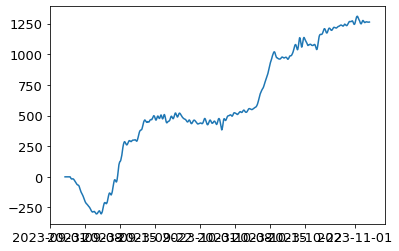

In [16]:
plt.plot(dtime_R, energy_wp)

In [17]:
### load topography data
path_topo = '/Users/chi/Documents/Data/Topography/GEBCO_23_Jan_2025/'
ds_topo = nc.Dataset(path_topo+'gebco_2024_n50.0_s5.0_w-98.0_e-30.0.nc')
# print(ds_topo)
lon_topo = ds_topo.variables['lon'][:]
lat_topo = ds_topo.variables['lat'][:]
elevation = ds_topo.variables['elevation'][:]
print(lon_topo.shape, lat_topo.shape, elevation.shape )

(16320,) (10800,) (10800, 16320)


/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_62850/2251491346.py:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(nrow ,ncol,1)
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_62850/2251491346.py:17: RuntimeWarning: All-NaN slice encountered
  data = np.nanmax( wp, axis=0 )
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_62850/2251491346.py:21: RuntimeWarning: All-NaN slice encountered
  data = np.nanmax( wp, axis=0 ) - np.nanmin( wp, axis=0 )
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_62850/2251491346.py:24: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(nrow ,ncol,3)
/var/folders/kq/vqqqnf_x6vd47tpg4lf57cjr0002p5/T/ipykernel_62850/2251491346.py:25: RuntimeWa

<Figure size 432x288 with 0 Axes>

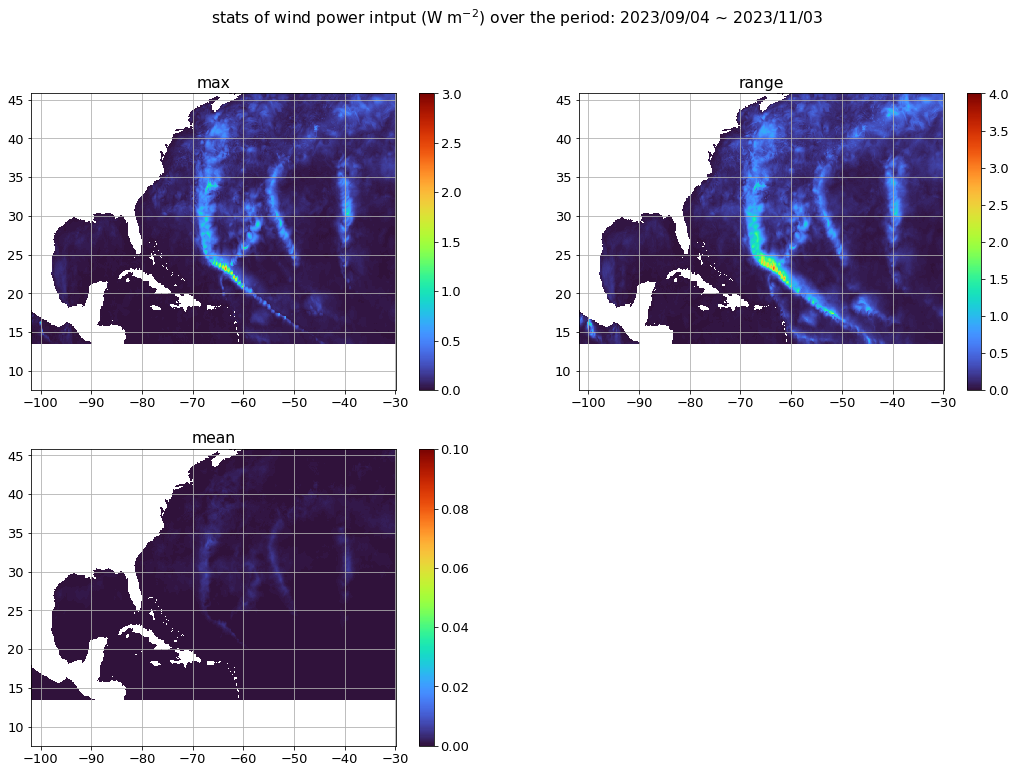

In [18]:
''' Plot map of ... over the selected period
(1) max wind power input
(2) range (max-min) of power input
(3) mean wind power
(4) 
'''
nrow = 2
ncol = 2
plt.clf()
plt.rcParams.update({'font.size': 13})
fig, axes = plt.subplots(nrow,1)
fig.set_size_inches(18, 12)
plt.suptitle('stats of wind power intput (W m$^{-2}$) over the period: '+dtime_R[0].strftime('%Y/%m/%d ~ ')+dtime_R[-1].strftime('%Y/%m/%d'))
str_stats = ['max','range','mean']
''' max '''
plt.subplot(nrow ,ncol,1)
data = np.nanmax( wp, axis=0 )
cs = plt.pcolormesh(LON_R, LAT_R, data, cmap='turbo',vmin=0,vmax=3)
''' range '''
plt.subplot(nrow ,ncol,2)
data = np.nanmax( wp, axis=0 ) - np.nanmin( wp, axis=0 )
cs = plt.pcolormesh(LON_R, LAT_R, data, cmap='turbo',vmin=0,vmax=4)
''' mean '''
plt.subplot(nrow ,ncol,3)
data = np.nanmean( wp, axis=0 )
cs = plt.pcolormesh(LON_R, LAT_R, data, cmap='turbo',vmin=0,vmax=0.1)
for i in range( nrow*ncol-1 ):
    plt.subplot(nrow, ncol,i+1)
    plt.colorbar()
    plt.grid()
    if i< len(str_stats):
        plt.title(str_stats[i])
### save figure
plt.savefig('stats_wp({:.2f}f-{:.2f}f)_onMap('.format(n_f[0],n_f[1])+xylim_str+')_'+tlim_str+'.png',dpi=400,bbox_inches='tight')

The total area of the box is 9.199E+12 m^2 = 9.2E+06 km^2
This box input 2.512E-03 TW of power


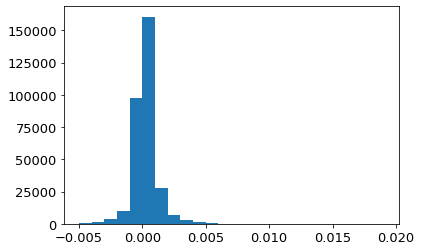

In [19]:
plt.hist(data.flatten(),np.arange(-0.005,0.02,0.001));
wp_mn = data
area_m2_total = 0
wp_total = 0
for i in range( len(LON_R)-1 ):
    for j in range( len(LAT_R)-1 ):
        # print(LON_R[i], LAT_R[j], wp_mn[j,i])
        if np.isnan( wp_mn[j,i] ) == 0: # only account for ocean grids
            obj = {'type':'Polygon','coordinates':[[[LON_R[0,i],LAT_R[j,0]],    [LON_R[0,i],LAT_R[j+1,0]],\
                                                    [LON_R[0,i+1],LAT_R[j+1,0]],[LON_R[0,i+1],LAT_R[j,0]],[LON_R[0,i],LAT_R[j,0]]]]}
            area_m2 = area(obj)
            # print(area_m2)
            area_m2_total = area_m2_total + area_m2
            wp_total = wp_total + wp_mn[j,i]*area_m2
            # break
print('The total area of the box is {:.3E} m^2 = {:.1E} km^2'.format(area_m2_total,area_m2_total*1e-6))
print('This box input {:.3E} TW of power'.format(wp_total*1e-12))